# Машинное обучение, DS-поток
## Задание ML.6

Задача 2: Исследование бустингов в задаче предсказания цены на жилье.
▫️ Пункт 1: наличие решения. (90.0)
▫️ В пункте про анализ максимальной глубины рассмотрено маленькое максимальное значение. Комм. Требуется не меньше 12. (-5.0)
▫️ Метрика отрисована только train/test части . Комм. Хотелось увидеть совместные графики на двух частях датасета для сравнения и на обучении и на валидации. Если смотреть только на обучении, то не получится найти переобучение. (-8.0)
▫️ Пункт 2: наличие решения. Инд. комм. Хороший и подробный вывод! Спасибо! (15.0)
▫️ Пункт 3: наличие решения. (15.0)
▫️ Маленький масштаб на параметр кол-ва деревьев. Комм. Можно было и побольше взять масштаб на кол-во моделей, т.к. метрика там улучшалась. Интересно было бы посмотреть есть ли у этого порог и он есть. Хотелось чтобы его нашли :). (-2.0)
Баллы: 105.0 / 120.0

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import catboost
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error as MAPE

sns.set(font_scale=1.3, palette='Set2')

---
### Задача 2

В файле `houses_train.csv` представлен набор данных про квартиры в городе Сиэтл, штат Вашингтон. Задача — предсказать цену на жилье по имеющимся данным.

Данные имеют следующие столбцы:
* `id` — идентификационный номер жилья
* `date` — дата продажи дома
* `price` — цена
* `bedrooms` — количество спален
* `bathrooms` — количество ванных комнат, где .5 означает комнату с туалетом, но без душа
* `sqft_living` — площадь жилья
* `sqft_lot` — площадь участка
* `floors` — количество этажей
* `waterfront` — видна ли набережная
* `view` — насколько хороший вид
* `condition` — индекс от 1 от 5, отвечающий за состояние квартиры
* `grade` — 1 до 13, 1-3 соответствует плохому уровню строительства и дизайна, 3-7 — средний уровень, 11-13 — высокий.
* `sqft_above` — жилая площадь над уровнем земли
* `sqft_basement` — жилая площадь под уровнем земли
* `yr_built` — год постройки жилья
* `yr_renovated` — год последней реконструкции жилья
* `zipcode` — почтовый индекс
* `lat` — широта
* `long` — долгота
* `sqft_living15` — средняя площадь жилья ближайших 15-и соседей
* `sqft_lot15` — средняя площадь участка ближайших 15-и соседей

В следующей задаче вы будете работать с ними в рамках Kaggle-соревнования. Предлагаем сначала подготовиться к нему, исследовав работу различных бустинг-библиотек применительно к этим данных. Результаты этой задаче вы сможете использовать в качестве начального решения соревнования.

**1.** Исследуйте зависимость качества по метрике MAPE для моделей 
* XGBoost, 
* LightGBM, 
* CatBoost, 
* а так же градиентного бустинга из sklearn, 

в зависимости от
* количества деревьев, 
* их максимальной глубины, 
* шага обучения, 
* $\ell_1$ и $\ell_2$ регуляризаций. 

При исследовании одного гиперпараметра рисуйте один график для всех моделей. Тщательно подберите цвета и тип линий, масштаб осей так, чтобы картинка была легко читаемой. При проведении исследований не забывайте писать подробные комментариии и выводы.

*Советы.*
* Используйте код с семинаров.
* Пока мы не умеем работать с признаком `zipcode`, удалите его из данных.

*Замечания.*
* Не забывайте, что для некоторых параметров стоит генерировать сетку значений при помощи `np.logspace`.

In [4]:
df = pd.read_csv('houses_train.csv')
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].apply(lambda x: x.timestamp())
df.drop('zipcode', axis=1, inplace=True)
df.head()

id          date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   3392  1.444694e+09  221900.0         3       1.00         1180      5650   
1  18295  1.449619e+09  538000.0         3       2.25         2570      7242   
2  14569  1.449619e+09  604000.0         4       3.00         1960      5000   
3  14081  1.455754e+09  510000.0         3       2.00         1680      8080   
4   6725  1.435363e+09  257500.0         3       2.25         1715      6819   

   floors  waterfront  view  condition  grade  sqft_above  sqft_basement  \
0     1.0           0     0          3      7        1180              0   
1     2.0           0     0          3      7        2170            400   
2     1.0           0     0          5      7        1050            910   
3     1.0           0     0          3      8        1680              0   
4     2.0           0     0          3      7        1715              0   

   yr_built  yr_renovated      lat     long  sqft_living15  sqft_lot15  
0      1955             0  47.5112 -122.257           1340        5650  
1      1951          1991  47.7210 -122.319           1690        7639  
2      1965             0  47.5208 -122.393           1360        5000  
3      1987             0  47.6168 -122.045           1800        7503  
4      1995             0  47.3097 -122.327           2238        6819

In [5]:
y = df['price']
X = df.drop(['price', 'id'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
preds_xgb = []
preds_lgb = []
preds_cat = []
preds_skl = []

n_estimators = np.arange(5, 305, 15)
for n in tqdm(n_estimators):
    xgb_model = XGBRegressor(n_estimators=n)
    lgb_model = LGBMRegressor(n_estimators=n, verbose=0)
    cat_model = CatBoostRegressor(n_estimators=n, verbose=0)
    skl_model = GradientBoostingRegressor(n_estimators=n)

    xgb_model.fit(X_train, y_train)
    lgb_model.fit(X_train, y_train)
    cat_model.fit(X_train, y_train)
    skl_model.fit(X_train, y_train)

    pred_xgb = xgb_model.predict(X_test)
    pred_lgb = lgb_model.predict(X_test)
    pred_cat = cat_model.predict(X_test)
    pred_skl = skl_model.predict(X_test)

    preds_xgb.append(pred_xgb)
    preds_lgb.append(pred_lgb)
    preds_cat.append(pred_cat)
    preds_skl.append(pred_skl)

100%|██████████| 20/20 [01:29<00:00,  4.45s/it]


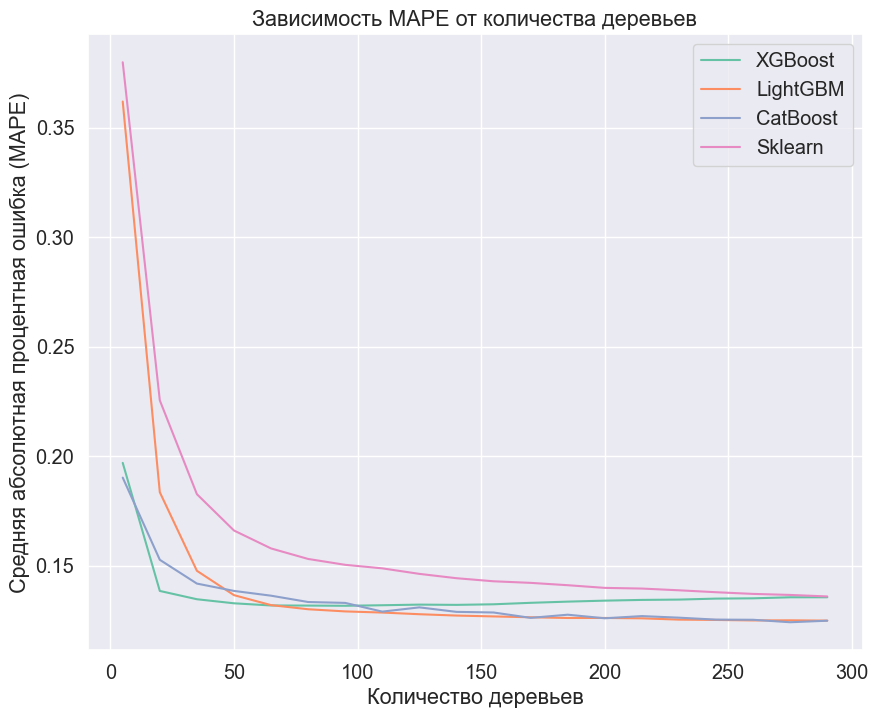

In [9]:
plt.figure(figsize=(10, 8))

y_test_np = np.array(y_test)

plt.plot(n_estimators, (np.abs(np.array(preds_xgb) - y_test_np[None, :]) / y_test_np[None, :]).mean(axis=1), label='XGBoost')
plt.plot(n_estimators, (np.abs(np.array(preds_lgb) - y_test_np[None, :]) / y_test_np[None, :]).mean(axis=1), label='LightGBM')
plt.plot(n_estimators, (np.abs(np.array(preds_cat) - y_test_np[None, :]) / y_test_np[None, :]).mean(axis=1), label='CatBoost')
plt.plot(n_estimators, (np.abs(np.array(preds_skl) - y_test_np[None, :]) / y_test_np[None, :]).mean(axis=1), label='Sklearn')

plt.title('Зависимость MAPE от количества деревьев')
plt.xlabel('Количество деревьев')
plt.ylabel('Средняя абсолютная процентная ошибка (MAPE)')

plt.legend()
plt.grid(True)

plt.show()


У всех методов, кроме XGBoost с увеличением количества деревьев ошибка уменьшается. Это происходит из-за переобучения XGBoost.

In [ ]:
preds_xgb = []
preds_lgb = []
preds_cat = []
preds_skl = []

max_depth = np.arange(1, 11)
for n in tqdm(max_depth):
    xgb_model = XGBRegressor(max_depth=n)
    lgb_model = LGBMRegressor(max_depth=n, verbose=0)
    cat_model = CatBoostRegressor(max_depth=n, verbose=0)
    skl_model = GradientBoostingRegressor(max_depth=n)

    xgb_model.fit(X_train, y_train)
    lgb_model.fit(X_train, y_train)
    cat_model.fit(X_train, y_train)
    skl_model.fit(X_train, y_train)

    pred_xgb = xgb_model.predict(X_test)
    pred_lgb = lgb_model.predict(X_test)
    pred_cat = cat_model.predict(X_test)
    pred_skl = skl_model.predict(X_test)

    preds_xgb.append(pred_xgb)
    preds_lgb.append(pred_lgb)
    preds_cat.append(pred_cat)
    preds_skl.append(pred_skl)

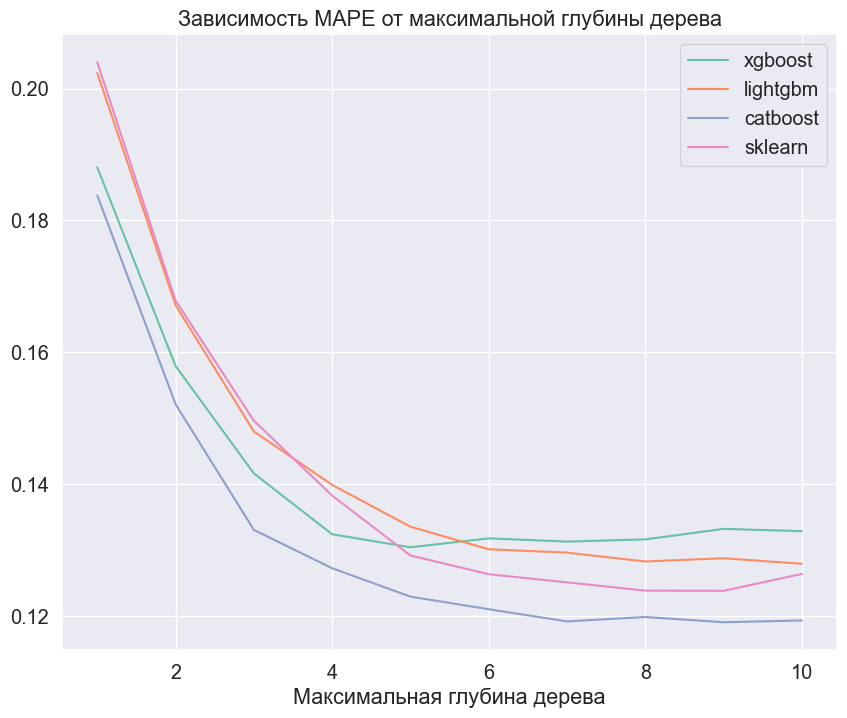

In [12]:
plt.figure(figsize=(10, 8))

plt.plot(max_depth, (np.abs(np.array(preds_xgb) - y_test_np[None, :]) / y_test_np[None, :]).mean(axis=1), label='xgboost')
plt.plot(max_depth, (np.abs(np.array(preds_lgb) - y_test_np[None, :]) / y_test_np[None, :]).mean(axis=1), label='lightgbm')
plt.plot(max_depth, (np.abs(np.array(preds_cat) - y_test_np[None, :]) / y_test_np[None, :]).mean(axis=1), label='catboost')
plt.plot(max_depth, (np.abs(np.array(preds_skl) - y_test_np[None, :]) / y_test_np[None, :]).mean(axis=1), label='sklearn')
plt.title('Зависимость MAPE от максимальной глубины дерева')
plt.xlabel('Максимальная глубина дерева')
plt.legend()

Для всех методов с увеличением глубины ошибка уменьшается до какого-то момента, потом происходит переобучение и ошибка либо перестает уменьшаться, либо увеличивается

In [13]:
preds_xgb = []
preds_lgb = []
preds_cat = []
preds_skl = []

lr = np.logspace(-3, 0, 10)

for n in tqdm(lr):
    xgb_model = XGBRegressor(learning_rate=n)
    lgb_model = LGBMRegressor(learning_rate=n, verbose=0)
    cat_model = CatBoostRegressor(learning_rate=n, verbose=0)
    skl_model = GradientBoostingRegressor(learning_rate=n)

    xgb_model.fit(X_train, y_train)
    lgb_model.fit(X_train, y_train)
    cat_model.fit(X_train, y_train)
    skl_model.fit(X_train, y_train)

    pred_xgb = xgb_model.predict(X_test)
    pred_lgb = lgb_model.predict(X_test)
    pred_cat = cat_model.predict(X_test)
    pred_skl = skl_model.predict(X_test)

    preds_xgb.append(pred_xgb)
    preds_lgb.append(pred_lgb)
    preds_cat.append(pred_cat)
    preds_skl.append(pred_skl)

100%|██████████| 10/10 [01:02<00:00,  6.28s/it]


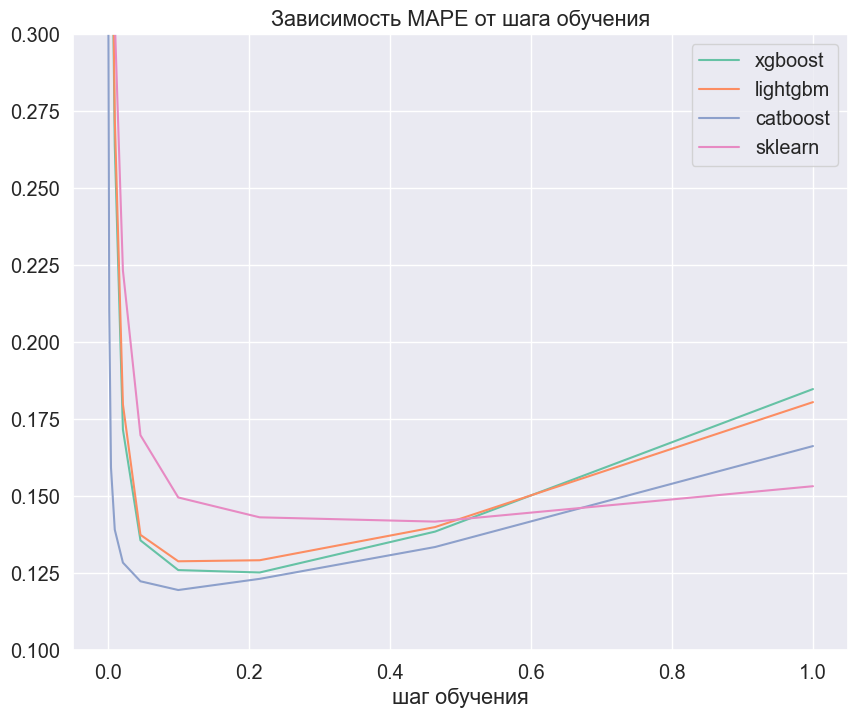

In [16]:
plt.figure(figsize=(10, 8))

plt.plot(lr, (np.abs(np.array(preds_xgb) - y_test_np[None, :]) / y_test_np[None, :]).mean(axis=1), label='xgboost')
plt.plot(lr, (np.abs(np.array(preds_lgb) - y_test_np[None, :]) / y_test_np[None, :]).mean(axis=1), label='lightgbm')
plt.plot(lr, (np.abs(np.array(preds_cat) - y_test_np[None, :]) / y_test_np[None, :]).mean(axis=1), label='catboost')
plt.plot(lr, (np.abs(np.array(preds_skl) - y_test_np[None, :]) / y_test_np[None, :]).mean(axis=1), label='sklearn')
plt.title('Зависимость MAPE от шага обучения')
plt.xlabel('шаг обучения')
plt.ylim(0.1, 0.3)
plt.legend()

Для всех методах ошибка сначала резко уменьшается, а затем постепенно начинает увеличиваться

Также заметим, что catboost лучше всех остальных при малом шаге обучения

In [17]:
preds_xgb = []
preds_lgb = []

alpha = np.logspace(-3, 3, 10)

for n in tqdm(alpha):
    xgb_model = XGBRegressor(reg_alpha=n)
    lgb_model = LGBMRegressor(reg_alpha=n, verbose=0)

    xgb_model.fit(X_train, y_train)
    lgb_model.fit(X_train, y_train)

    pred_xgb = xgb_model.predict(X_test)
    pred_lgb = lgb_model.predict(X_test)

    preds_xgb.append(pred_xgb)
    preds_lgb.append(pred_lgb)

100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


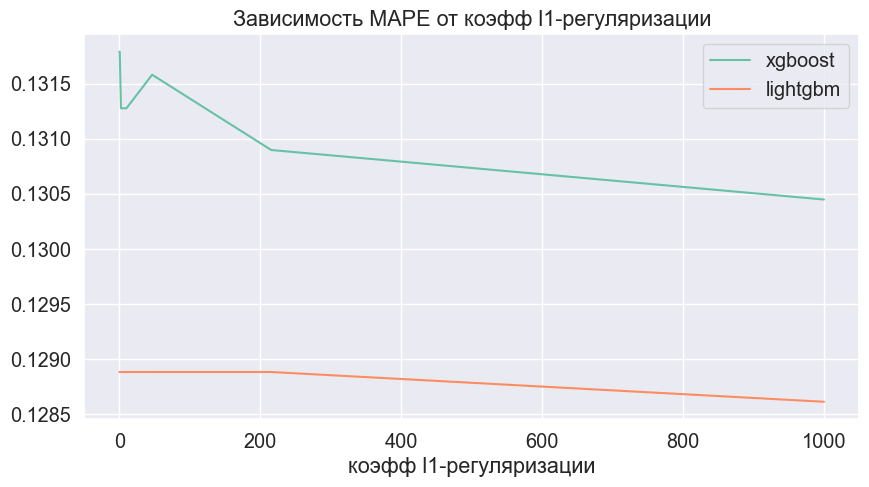

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(alpha, (np.abs(np.array(preds_xgb) - y_test_np[None, :]) / y_test_np[None, :]).mean(axis=1), label='xgboost')
plt.plot(alpha, (np.abs(np.array(preds_lgb) - y_test_np[None, :]) / y_test_np[None, :]).mean(axis=1), label='lightgbm')
plt.title('Зависимость MAPE от коэфф l1-регуляризации')
plt.xlabel('коэфф l1-регуляризации')
plt.legend()

Изменения качества очень малы, в данном датасете l1-регуляризация практически не влияет

In [20]:
preds_xgb = []
preds_lgb = []
preds_cat = []

lambd = np.logspace(-3, 3, 10)

for n in tqdm(lambd):
    xgb_model = XGBRegressor(reg_lambda=n)
    lgb_model = LGBMRegressor(reg_lambda=n, verbose=0)
    cat_model = CatBoostRegressor(reg_lambda=n, verbose=0)

    xgb_model.fit(X_train, y_train)
    lgb_model.fit(X_train, y_train)
    cat_model.fit(X_train, y_train)

    pred_xgb = xgb_model.predict(X_test)
    pred_lgb = lgb_model.predict(X_test)
    pred_cat = cat_model.predict(X_test)

    preds_xgb.append(pred_xgb)
    preds_lgb.append(pred_lgb)
    preds_cat.append(pred_cat)

100%|██████████| 10/10 [00:37<00:00,  3.78s/it]


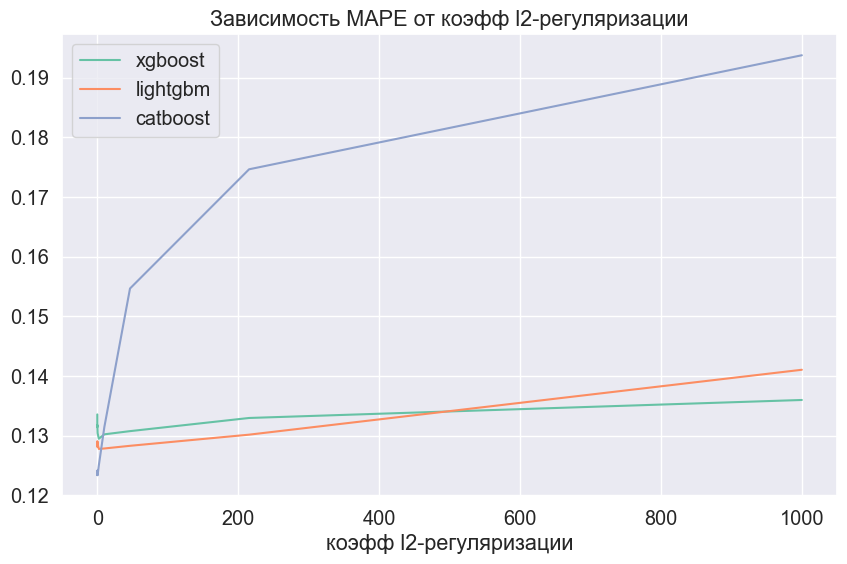

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(lambd, (np.abs(np.array(preds_xgb) - y_test_np[None, :]) / y_test_np[None, :]).mean(axis=1), label='xgboost')
plt.plot(lambd, (np.abs(np.array(preds_lgb) - y_test_np[None, :]) / y_test_np[None, :]).mean(axis=1), label='lightgbm')
plt.plot(lambd, (np.abs(np.array(preds_cat) - y_test_np[None, :]) / y_test_np[None, :]).mean(axis=1), label='catboost')
plt.title('Зависимость MAPE от коэфф l2-регуляризации')
plt.xlabel('коэфф l2-регуляризации')
plt.legend()

Catboosty l2-регуляризация только мешает, на остальные практически не влияет

**2.** Нарисуйте по несколько деревьев каждой из моделей с помощью функций `plot_tree`, которая реализована в каждой из библиотек. Для этого потребуется немного разобраться с тем, как работают эти функции. 

Какие особенности можно заметить? Как меняются деревья при изменении максимальной глубины? Что выдает CatBoost в листе, если в него не попали объекты обучающей выборки?

In [ ]:
cat_models = []
xgb_models = []
lgb_models = []

max_depth = [2, 4, 8]
for n in tqdm(max_depth):
    xgb_model = XGBRegressor(max_depth=n)
    lgb_model = LGBMRegressor(max_depth=n, verbose=0)
    cat_model = CatBoostRegressor(max_depth=n, verbose=0)

    xgb_model.fit(X_train, y_train)
    lgb_model.fit(X_train, y_train)
    cat_model.fit(X_train, y_train)

    xgb_models.append(xgb_model)
    lgb_models.append(lgb_model)
    cat_models.append(cat_model)

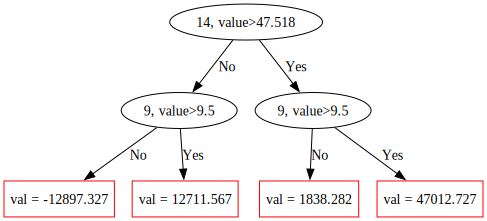

In [5]:
cat_models[0].plot_tree(0)

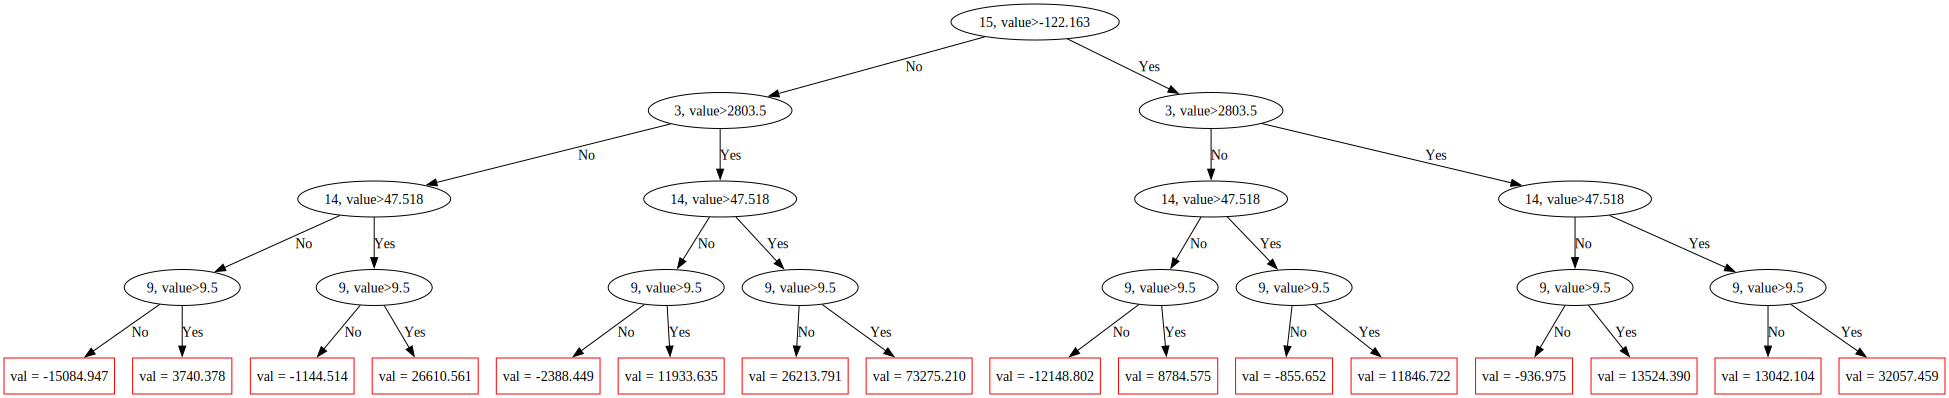

In [6]:
cat_models[1].plot_tree(0)

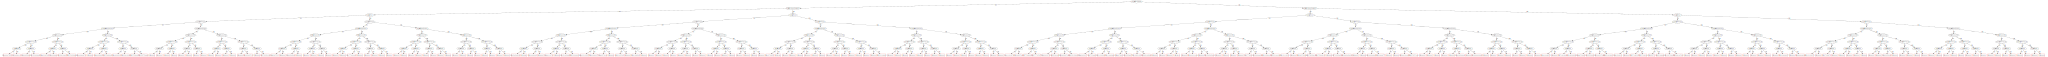

In [7]:
cat_models[2].plot_tree(0)

вывод 

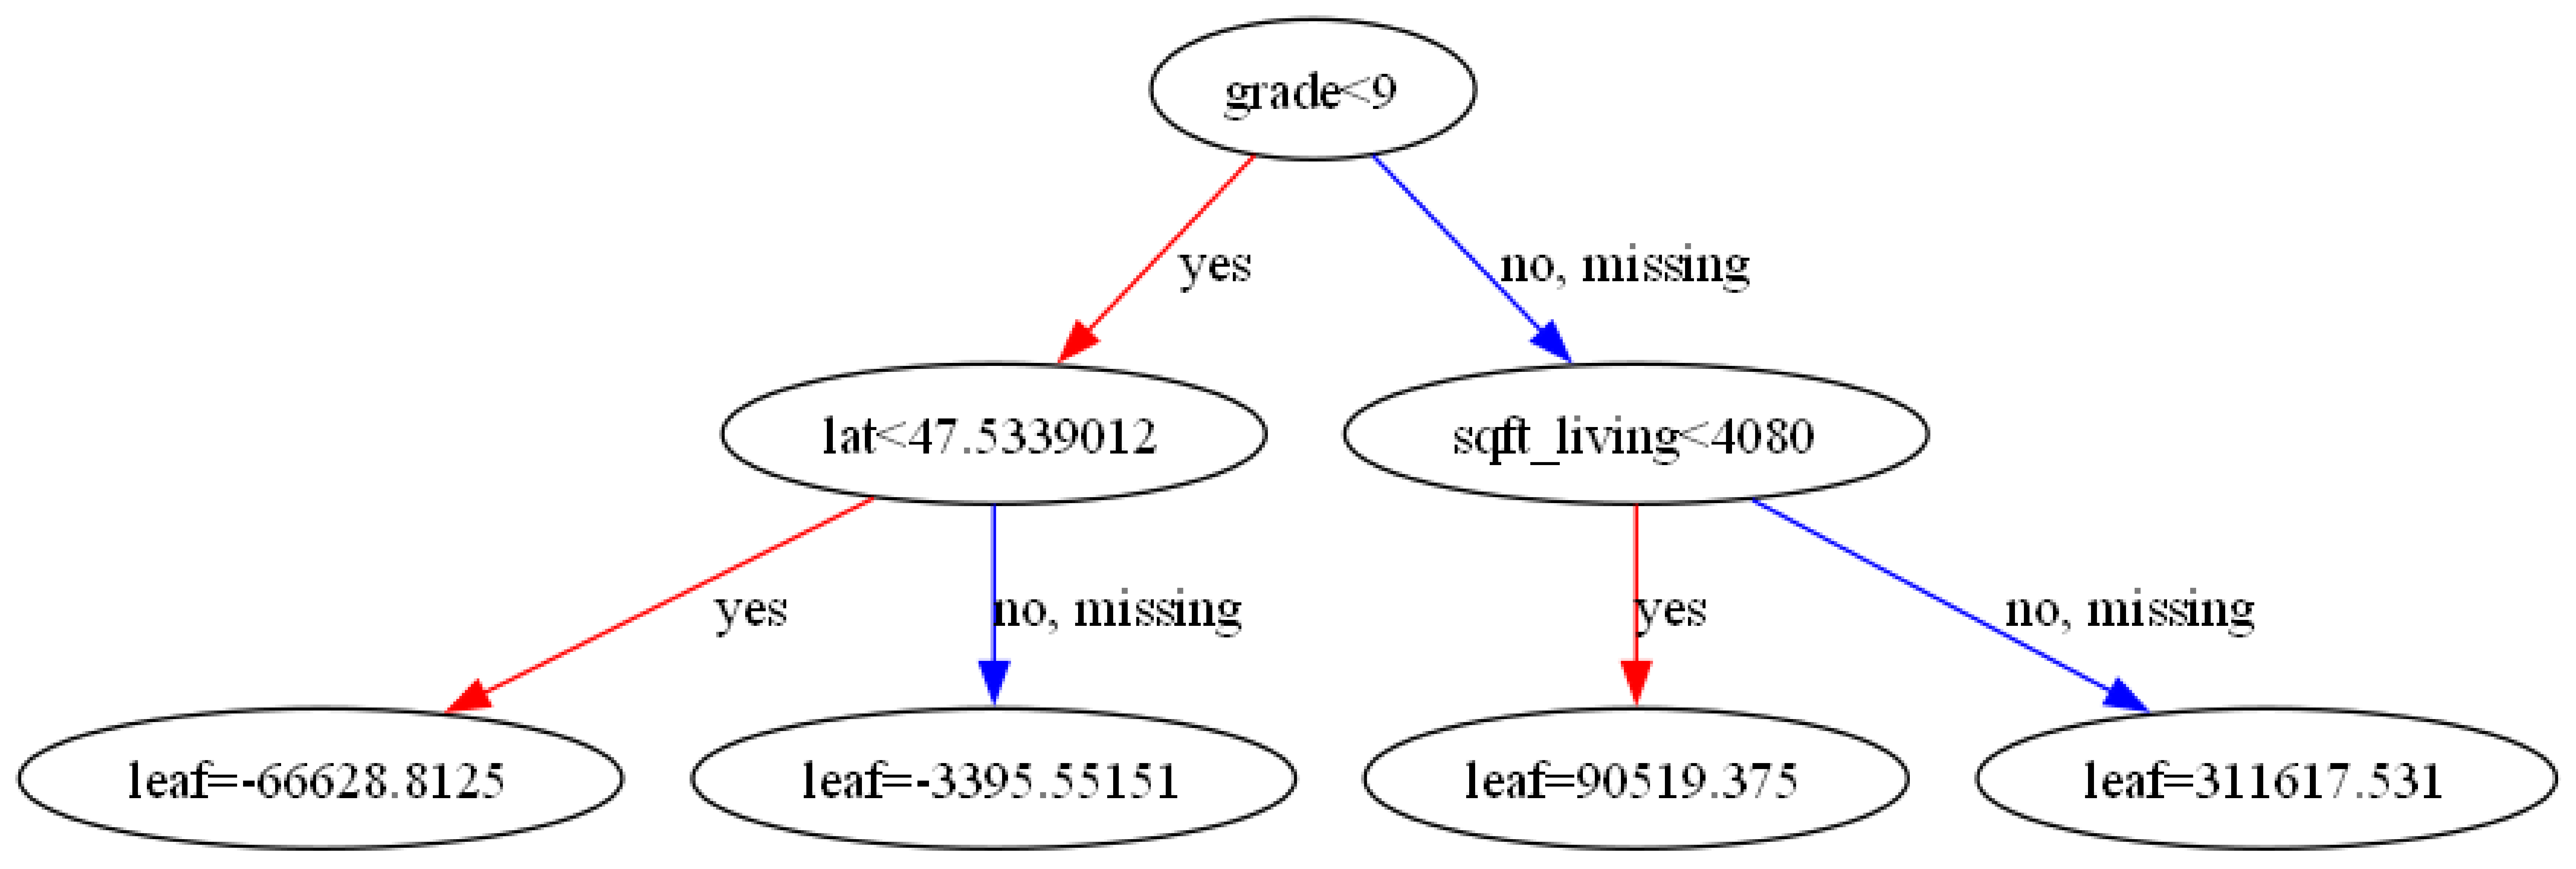

In [8]:
fig, ax = plt.subplots(figsize=(100, 30))
xgb.plot_tree(xgb_models[0], num_trees=0, ax=ax)
plt.show()

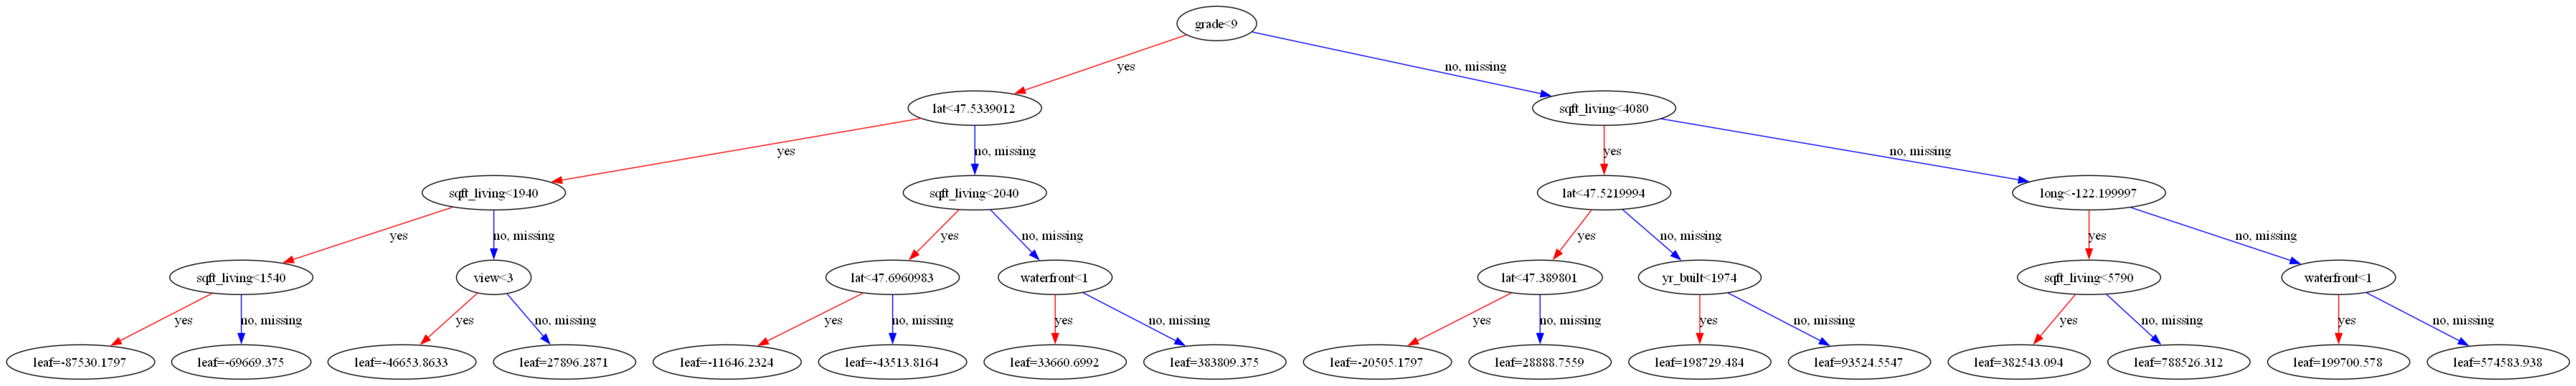

In [9]:
fig, ax = plt.subplots(figsize=(120, 100))
xgb.plot_tree(xgb_models[1], num_trees=0, ax=ax)
plt.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.905041 to fit


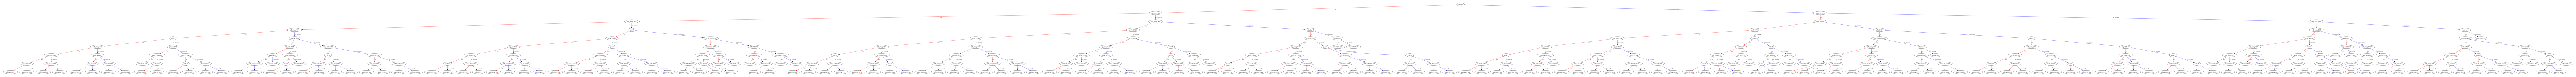

In [10]:
fig, ax = plt.subplots(figsize=(120, 100))
xgb.plot_tree(xgb_models[2], num_trees=0, ax=ax)
plt.show()

<Axes: >

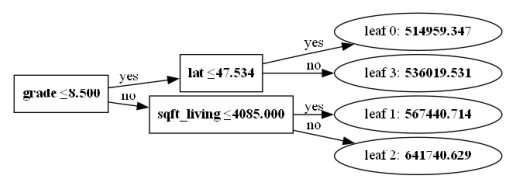

In [11]:
lgb.plot_tree(lgb_models[0], tree_index=0)

<Axes: >

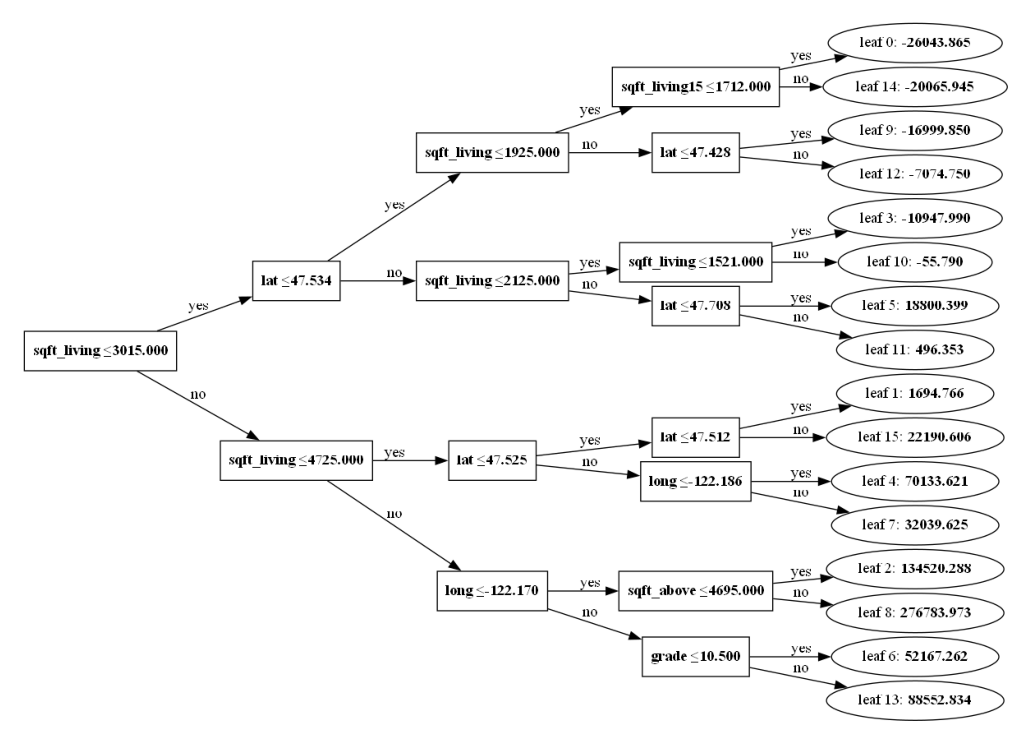

In [12]:
lgb.plot_tree(lgb_models[1], tree_index=1, dpi=200)

<Axes: >

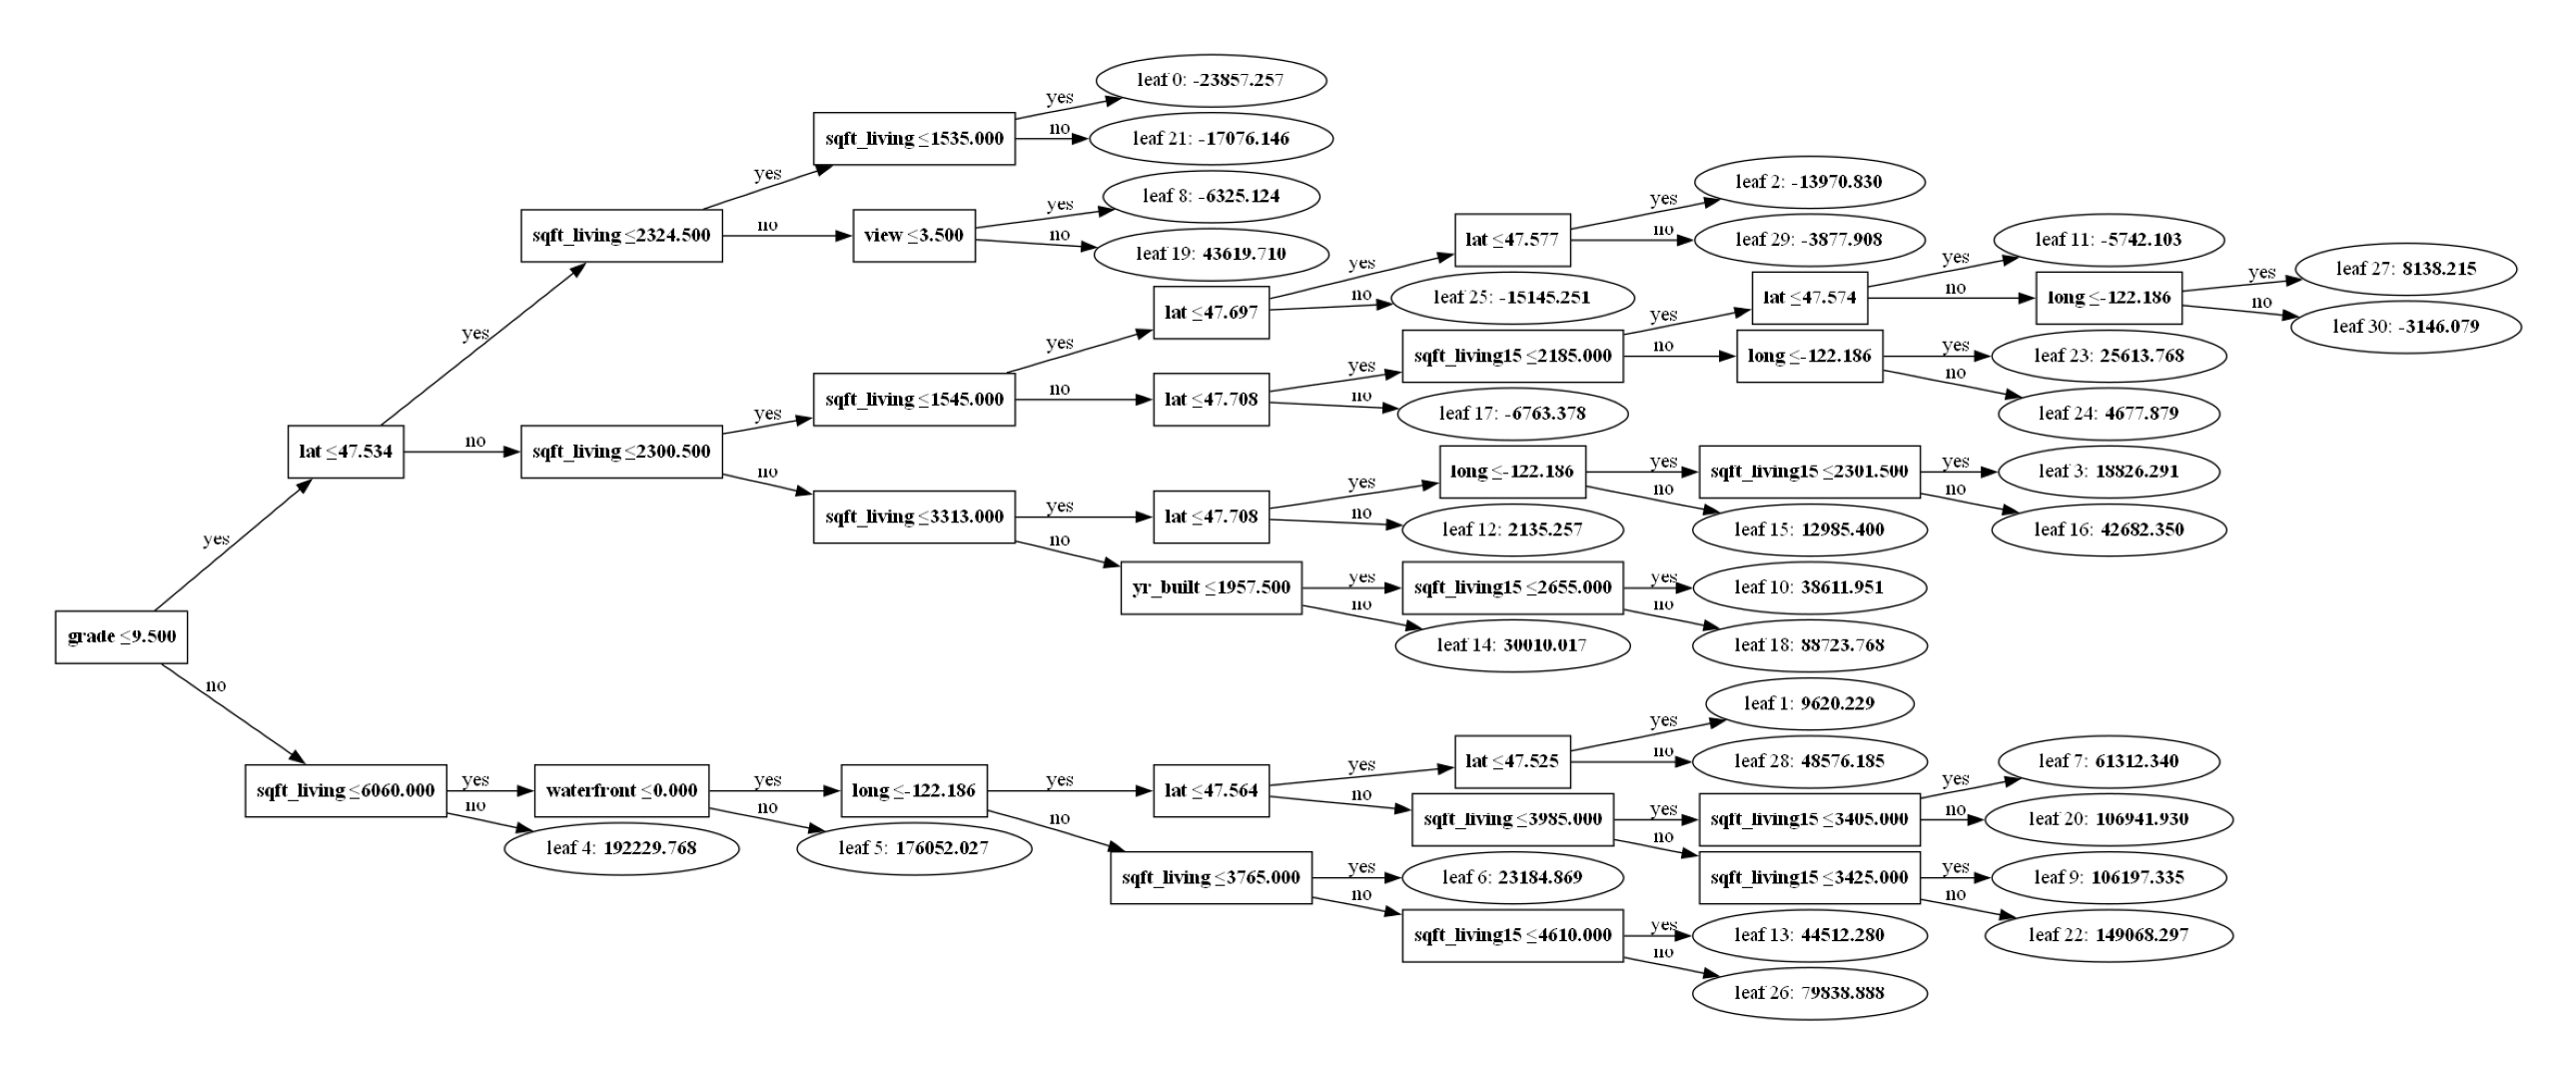

In [13]:
lgb.plot_tree(lgb_models[2], tree_index=2, dpi=500)

- **XGBoost**:
  - Деревья XGBoost обычно строятся сбалансированными, с глубиной, строго контролируемой параметром `max_depth`. XGBoost выбирает разбиения так, чтобы минимизировать функцию потерь на каждом шаге.
  - Поскольку XGBoost использует жадный алгоритм выбора разбиений, деревья могут быть "жесткими", то есть решения основаны на жестких правилах разделения данных.
  - При увеличении глубины деревьев, XGBoost становится способным обучаться на более сложных паттернах, увеличивается вероятность переобучения. Глубокие деревья позволяют моделировать сложные нелинейные зависимости, но в то же время могут вызывать чрезмерную подгонку под обучающие данные.
  - При малой глубине деревья становятся более простыми, что снижает риск переобучения, но может привести к недостаточному обучению.


- **LightGBM**:
  - LightGBM строит деревья по схеме "Leaf-wise" (разбиение листьев), а не по уровню, как в XGBoost. Это позволяет строить более глубокие деревья для одной ветви, если это помогает минимизировать ошибку.
  - LightGBM может давать более компактные деревья, которые в некоторых случаях лучше обобщают, но могут вызывать переобучение, если глубина слишком велика.
  - Из-за стратегии построения деревьев "Leaf-wise" при увеличении глубины деревьев LightGBM может строить гораздо более сложные и асимметричные деревья. Это позволяет моделировать тонкие различия в данных, но слишком большие деревья могут привести к переобучению.
  - При низкой глубине LightGBM может недообучаться, не раскрывая всех возможных паттернов в данных.

- **CatBoost**:
  - CatBoost использует несколько методов для обработки категориальных признаков и более сложные схемы построения деревьев, такие как комбинации деревьев с автоматической обработкой категорий.
  - Деревья CatBoost более симметричны, что связано с внутренними механизмами преобразования категориальных признаков.
  - Увеличение глубины деревьев в CatBoost также увеличивает способность модели к обучению на сложных паттернах, но CatBoost стремится избегать переобучения благодаря особенностям своей архитектуры и использованию специальных схем регуляризации.
  - При меньшей глубине деревья становятся проще, и модель может терять часть информации о сложных взаимодействиях в данных.


CatBoost использует особую стратегию для работы с листами, в которые не попали объекты обучающей выборки. Если лист оказывается пустым (в него не попали объекты из обучающего набора), то CatBoost присваивает листу среднее значение предсказаний для данного листа или близлежащих листьев, исходя из контекста дерева и предыдущих деревьев модели. 


**3.** Исследуйте среднее время обучения и предсказания для разных моделей. Для более честного сравнения для каждой модели стоит использовать те значения гиперпараметров, которые для нее оптимальны.

In [18]:
%%timeit
cat_m = CatBoostRegressor()
cat_m.fit(X_train, y_train, verbose=0)


3.39 s ± 112 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%%timeit
xgb_m = XGBRegressor()
xgb_m.fit(X_train, y_train)

181 ms ± 39.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%%timeit
lgb_m = LGBMRegressor()
lgb_m.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2493
[LightGBM] [Info] Number of data points in the train set: 12500, number of used features: 18
[LightGBM] [Info] Start training from score 532968.600480
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2493
[LightGBM] [Info] Number of data points in the train set: 12500, number of used features: 18
[LightGBM] [Info] Start training from score 532968.600480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info

XGBRegressor и LGBMRegressor имеют примерно одинаковое время обучения, CatBoostRegressor же примерно в 20 раз дольше обучается

In [21]:
cat_m = CatBoostRegressor()
cat_m.fit(X_train, y_train, verbose=0)
xgb_m = XGBRegressor()
xgb_m.fit(X_train, y_train)
lgb_m = LGBMRegressor()
lgb_m.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2493
[LightGBM] [Info] Number of data points in the train set: 12500, number of used features: 18
[LightGBM] [Info] Start training from score 532968.600480


LGBMRegressor()

In [22]:
%%timeit
cat_m.predict(X_test)

2.68 ms ± 48.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
%%timeit
xgb_m.predict(X_test)

6.62 ms ± 107 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
%%timeit
lgb_m.predict(X_test)

6.64 ms ± 115 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


А вот время предикта у катбуста в 3 раза меньше, чем у двух других методов

**Выводы:**
XGBoost, LightGBM и CatBoost — это мощные алгоритмы градиентного бустинга, каждый из которых имеет свои особенности. XGBoost строит сбалансированные деревья и контролирует глубину, что делает его стабильным, но подверженным переобучению при слишком глубоких деревьях. LightGBM использует разбиение по листьям, создавая асимметричные деревья, что позволяет более эффективно обрабатывать большие данные, но может привести к переобучению. CatBoost выделяется продвинутой обработкой категориальных признаков и симметричными деревьями, что помогает избежать переобучения и эффективно работать с категориальными данными.